$\textbf{IMPORTS}$

In [22]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import csv
import json
import time
import tqdm
import os
import pprint
import pandas as pd
from pathlib import Path
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, KFold, cross_val_score



$\textbf{LOAD ALL PAGES}$, BOLIGA.DK

In [ ]:
#1.Load pages boliga.dk
links = []
for page in range(1,146): #check the number of pages in link before running this code!!
    url_boliga = f'https://www.boliga.dk/resultat?propertyType=3&page={page}&sort=daysForSale-a'
    links.append(url_boliga)

$\textbf{LOGGING FUNCTION}$

In [ ]:
# Define the log function to gather the log information
def log(response,logfile,output_path=os.getcwd()):
    # Open or create the csv file
    if os.path.isfile(logfile): #If the log file exists, open it and allow for changes     
        log = open(logfile,'a')
    else: #If the log file does not exist, create it and make headers for the log variables
        log = open(logfile,'w')
        header = ['timestamp','status_code','length','output_file']
        log.write(';'.join(header) + "\n") #Make the headers and jump to new line
        
    # Gather log information
    status_code = response.status_code #Status code from the request result
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())) #Local time
    length = len(response.text) #Length of the HTML-string
    
    # Open the log file and append the gathered log information
    with open(logfile,'a') as log:
        log.write(f'{timestamp};{status_code};{length};{output_path}' + "\n") #Append the information and jump to new line

$\textbf{SCRAPE DATA FROM EACH PAGE}$, BOLIGA.DK

In [ ]:
#1, Combinale all code above in a loop to scrape all pages
add = []
p = []
zipc = []
m_2 = []
rooms_ = []

log_boliga = 'log_boliga.csv'
for i in links:
    response = requests.get(i, headers={'name':'Sevda Öztürk','email':'txg194b@alumni.ku.dk', "note": "I am a student extracting data from this webpage. If you have any problem or concern, email me."})
    soup = BeautifulSoup(response.content,"xml")
    
    #append address to list
    list_address = soup.find_all("div" ,class_ = 'w-100 mt-1 listing-address font-weight-bold text-nowrap text-truncate')
    address = [col.text.split(",",1)[0] for col in list_address]
    add.append(address)
    #convert list of lists to ONE LIST
    address_final = []
    for sublist in add:
        for item in sublist:
            address_final.append(item)
    
    #append price to list
    list_price = soup.find_all("div" , class_ ="price m-0 d-flex align-items-center")
    price = [col.text.split("k",1)[0] for col in list_price]
    p.append(price)
    #convert list of lists to ONE LIST
    price_final = []
    for sublist in p:
        for item in sublist:
            price_final.append(item)
    
    #append zipcode to list
    list_zipcode = soup.find_all("div" ,class_ = "zip-color text-nowrap text-truncate")
    zipcode = [col.text for col in list_zipcode]
    zipc.append(zipcode)
     #convert list of lists to ONE LIST
    zipcode_final = []
    for sublist in zipc:
        for item in sublist:
            zipcode_final.append(item)
    
    #append m2 to list
    list_m2 = soup.find_all("span" ,class_ = "text-nowrap")
    m2 = [col.text.split() for col in list_m2]
    #the variable m2 is a list of lists. The following code keeps the first element of every sublist to get rid of the string "m2"
    m2 = [element[0] for element in m2]
    del m2[0] #delete first element in m2 in order to get all m2 in next code
    m2 = m2[::6] #we now keep every 6th element, which is the size of every address
    m_2.append(m2)
    #convert list of lists to ONE LIST
    m2_final = []
    for sublist in m_2:
        for item in sublist:
            m2_final.append(item)
    
    #append room to list
    rooms = [col.text.split() for col in list_m2]
    rooms = [elements[1:] for elements in rooms]
    rooms = rooms[::6] #we now keep every 6th element, which is no. of rooms
    rooms_.append(rooms)
    #convert list of lists to ONE LIST
    rooms_fin = []
    for sublist in rooms_:
        for item in sublist:
            rooms_fin.append(item)
    rooms_final = []
    for sublist in rooms_fin:
        for item in sublist:
            rooms_final.append(item)
    #replace "værelse" with "1"
    for i in range(len(rooms_final)):
        if rooms_final[i] == "værelse":
            rooms_final[i] = "1"
    time.sleep(0.5) #Sleep for 0.5 seconds
    log(response,log_boliga)

$\textbf{COMBINE ALL CODE ABOVE INTO ONE DATAFRAME}$

In [ ]:
#1. Combine all scraped lists in one dataframe
df_addzip = {"Pris": price_final, "address": address_final, "zipcode": zipcode_final, "m2": m2_final, "rooms": rooms_final}
df_data = pd.DataFrame(df_addzip)

#2. save dataset as v1
df_data.to_csv("v1.csv")
df_data

$\textbf{GET  DISTANCES}, \ dataforsyningen.dk, \ hvorlangterder.dk$

In [ ]:
## 1. Load pages
Address_zipcode = df_data["address"] + " " + df_data["zipcode"]
add_zip = []
log_dataforsyning = 'log_dataforsyning.csv'
for i in Address_zipcode:
    response_dist = requests.get(f"https://api.dataforsyningen.dk/adresser?q={i}&struktur=mini", headers={'name':'Sevda Öztürk','email':'txg194b@alumni.ku.dk', "note": "I am a student extracting data from this webpage. If you have any problem or concern, email me."})
    res_j = response_dist.json()
    add_zip.append(res_j)
    time.sleep(0.5) #Sleep for 0.5 seconds
    log(response_dist,log_dataforsyning)

Before continuing, locate missing values due to typing error in column "address" in df_data

In [ ]:
#2. Locate missing values
df_add_zip = pd.DataFrame(add_zip)
index = df_add_zip[df_add_zip[0].isnull()][0]

#3. Store index numbers in order to del the corresponding indexes in df_data
index_list = list(index.index.values)

#4. Delete corresponding rows in df_data
for i in index_list:
    df_add_zip.drop(i, inplace=True)

#5. reset_index keeps failing, so here comes another index-method    
df_add_zip["new_index"] = range(len(df_add_zip))
df_add_zip.set_index("new_index", inplace=True)

Drop missing values in df_data

In [ ]:
#6. Delete corresponding rows in df_data
for i in index_list:
    df_data.drop(i, inplace=True)

#reset_index keeps failing, so here comes another index-method    
df_data["new_index"] = range(len(df_data))
df_data.set_index("new_index", inplace=True)

In [ ]:
#7. save dataset with dropped missing values as v2
df_data.to_csv("v2.csv")
df_data
#Vi mister 151 observationer efter fjernelse af ovenstående obs

In [ ]:
#8. Get longitude, x, and latitudes, y from address i
x = []
y = []

for i in range(len(df_add_zip)):
    xx = df_add_zip[0][i]["x"]
    x.append(xx)

for i in range(len(df_add_zip)):
    yy = df_add_zip[0][i]["y"]
    y.append(yy)

In [ ]:
#9. Add coordinates to df_data
df_data["x"] = x
df_data["y"] = y
xy = df_data["y"].apply(str) +","+ df_data["x"].apply(str)

In [ ]:
#10 Get distance to nearest x
daycare_distance = []
log_dist = 'log_dist'
for i in tqdm.tqdm(xy):
    afstand_daycare_json = requests.get(f'https://hvorlangterder.poi.viamap.net/v1/nearestpoi/?token=eyJkcGZ4IjogImh2b3JsYW5ndGVyZGVyIiwgInJlZiI6ICIyIiwgInBhciI6ICIiLCAicHJpdnMiOiAicjFaMHIwRjBrNkJ0V3FRY09VeWtCL3k2U1VwSnYyUWJneVhldHE0SFk0WE8vM1lyVzArSzl3PT0ifQ.2HJhvgEQPhJZuxuNZcR2y5jhmCn1IQpvqgr337BOI3e1ZzW1YmDVJDfELUKBTSXKNKlhq+1h+B5rO6rpLunNhw&fromlatlng={i}&poitypes=daycare&decodepolyline',headers={'name':'Sevda Öztürk','email':'txg194b@alumni.ku.dk', "note": "I am a student extracting data from this webpage. If you have any problem or concern, email me."})
    afstand_daycare_json.json()
    key = afstand_daycare_json.json()['daycare']
    key = key['routedmeters']
    daycare_distance.append(key)
    time.sleep(0.5) #Sleep for 0.5 seconds
    log(afstand_daycare_json,log_dist)

In [ ]:
regionaltog_distance = []

for i in tqdm.tqdm(xy):
    afstand_regionaltog_json = requests.get(f'https://hvorlangterder.poi.viamap.net/v1/nearestpoi/?token=eyJkcGZ4IjogImh2b3JsYW5ndGVyZGVyIiwgInJlZiI6ICIyIiwgInBhciI6ICIiLCAicHJpdnMiOiAicjFaMHIwRjBrNkJ0V3FRY09VeWtCL3k2U1VwSnYyUWJneVhldHE0SFk0WE8vM1lyVzArSzl3PT0ifQ.2HJhvgEQPhJZuxuNZcR2y5jhmCn1IQpvqgr337BOI3e1ZzW1YmDVJDfELUKBTSXKNKlhq+1h+B5rO6rpLunNhw&fromlatlng={i}&poitypes=train&decodepolyline', headers={'name':'Sevda Öztürk','email':'txg194b@alumni.ku.dk', "note": "I am a student extracting data from this webpage. If you have any problem or concern, email me."})
    afstand_regionaltog_json.json()
    key = afstand_regionaltog_json.json()['train']
    key = key['routedmeters']
    regionaltog_distance.append(key)
    time.sleep(0.5) #Sleep for 0.5 seconds

In [ ]:
school_distance = []

for i in tqdm.tqdm(xy):
    afstand_school_json = requests.get(f'https://hvorlangterder.poi.viamap.net/v1/nearestpoi/?token=eyJkcGZ4IjogImh2b3JsYW5ndGVyZGVyIiwgInJlZiI6ICIyIiwgInBhciI6ICIiLCAicHJpdnMiOiAicjFaMHIwRjBrNkJ0V3FRY09VeWtCL3k2U1VwSnYyUWJneVhldHE0SFk0WE8vM1lyVzArSzl3PT0ifQ.2HJhvgEQPhJZuxuNZcR2y5jhmCn1IQpvqgr337BOI3e1ZzW1YmDVJDfELUKBTSXKNKlhq+1h+B5rO6rpLunNhw&fromlatlng={i}&poitypes=school&decodepolyline',headers={'name':'Sevda Öztürk','email':'txg194b@alumni.ku.dk', "note": "I am a student extracting data from this webpage. If you have any problem or concern, email me."})
    afstand_school_json.json()
    key = afstand_school_json.json()['school']
    key = key['routedmeters']
    school_distance.append(key)
    time.sleep(0.5) #Sleep for 0.5 seconds

In [ ]:
supermarket_distance = []

for i in tqdm.tqdm(xy):
    afstand_supermarket_json = requests.get(f'https://hvorlangterder.poi.viamap.net/v1/nearestpoi/?token=eyJkcGZ4IjogImh2b3JsYW5ndGVyZGVyIiwgInJlZiI6ICIyIiwgInBhciI6ICIiLCAicHJpdnMiOiAicjFaMHIwRjBrNkJ0V3FRY09VeWtCL3k2U1VwSnYyUWJneVhldHE0SFk0WE8vM1lyVzArSzl3PT0ifQ.2HJhvgEQPhJZuxuNZcR2y5jhmCn1IQpvqgr337BOI3e1ZzW1YmDVJDfELUKBTSXKNKlhq+1h+B5rO6rpLunNhw&fromlatlng={i}&poitypes=supermarket&decodepolyline',headers={'name':'Sevda Öztürk','email':'txg194b@alumni.ku.dk', "note": "I am a student extracting data from this webpage. If you have any problem or concern, email me."})
    afstand_supermarket_json.json()
    key = afstand_supermarket_json.json()['supermarket']
    key = key['routedmeters']
    supermarket_distance.append(key)
    time.sleep(0.5) #Sleep for 0.5 seconds

In [ ]:
hospital_distance = []

for i in tqdm.tqdm(xy):
    hospital_distance_json = requests.get(f'https://hvorlangterder.poi.viamap.net/v1/nearestpoi/?token=eyJkcGZ4IjogImh2b3JsYW5ndGVyZGVyIiwgInJlZiI6ICIyIiwgInBhciI6ICIiLCAicHJpdnMiOiAicjFaMHIwRjBrNkJ0V3FRY09VeWtCL3k2U1VwSnYyUWJneVhldHE0SFk0WE8vM1lyVzArSzl3PT0ifQ.2HJhvgEQPhJZuxuNZcR2y5jhmCn1IQpvqgr337BOI3e1ZzW1YmDVJDfELUKBTSXKNKlhq+1h+B5rO6rpLunNhw&fromlatlng={i}&poitypes=hospital&decodepolyline',headers={'name':'Sevda Öztürk','email':'txg194b@alumni.ku.dk', "note": "I am a student extracting data from this webpage. If you have any problem or concern, email me."})
    hospital_distance_json.json()
    key = hospital_distance_json.json()['hospital']
    key = key['routedmeters']
    hospital_distance.append(key)
    time.sleep(0.5) #Sleep for 0.5 seconds

In [ ]:
#4 Add coordinates of addresses in dataframe
df_data["daycare_distance"] = daycare_distance
df_data["train_distance"] = regionaltog_distance
df_data["school_distance"] = school_distance
df_data["supermarket_distance"] = supermarket_distance
df_data["hospital_distance"] = hospital_distance

In [ ]:
#11. save dataset with distances
df_data.to_csv("v3.csv")
df_data

$\textbf{CONSTRUCT A VARIABEL FOR REGION}$

In [ ]:
#1. Load API
response_reg = requests.get(f"https://api.dataforsyningen.dk/regioner", headers={'name':'Sevda Öztürk','email':'txg194b@alumni.ku.dk', "note": "I am a student extracting data from this webpage. If you have any problem or concern, email me."})
res_reg = response_reg.json()

In [ ]:
#2. Get the coordinate intervals for each region
regions = []

for i in range(0,5):
    rg = res_reg[i]["bbox"]
    regions.append(rg)
regions

In [ ]:
#3. Use the coordinate intervals above to place each observation in a region
def region(df_data):
    
    if (8.18951662 < df_data['x'] < 11.22599137) and (56.53454667 < df_data['y'] < 57.76025478):  
        return 'Nordjylland'
    elif (8.07887623 <  df_data['x'] < 11.66419061) and (55.64437916 < df_data['y'] < 56.84325702): 
        return 'Midtjylland'
    elif (8.06320315 < df_data['x'] < 10.99555236) and (54.71828064 < df_data['y'] < 55.95324986):  
        return 'Syddanmark'
    elif (11.60211644 < df_data['x'] < 15.31831444) and (54.98354657 < df_data['y'] < 56.20520188):  
        return 'Hovedstaden'
    elif (10.8148054 < df_data['x'] < 12.64551576) and (54.54440636 < df_data['y'] < 56.0173058):  
        return 'Sjælland'
df_data['Region'] = df_data.apply(region, axis=1)
#display(df_data)

In [ ]:
#4. save dataset including regions
df_data.to_csv("v4.csv")
df_data

$\textbf{CLEAN DATASET}$

In [ ]:
#Clean dataset and save as v5

df_data = df_data.drop_duplicates().reset_index()
del df_data["new_index"]

df_data.Pris = df_data.Pris.astype(str)
df_data.Pris = df_data.Pris.str.replace('.', '', regex=True)

df_data["Pris"] = df_data["Pris"].apply(pd.to_numeric, errors='coerce')

df_data.to_csv("v5.csv")

In [2]:
df_data = pd.read_csv('v5.csv', index_col=[0])

In [3]:
df_data = pd.get_dummies(df_data, columns=['Region'])

df_data['Pris'] = np.log2(df_data['Pris'])
df_data

,Pris,address,zipcode,m2,rooms,x,y,daycare_distance,train_distance,school_distance,supermarket_distance,hospital_distance,Region_Hovedstaden,Region_Midtjylland,Region_Nordjylland,Region_Sjælland,Region_Syddanmark
0,20.775552,Kvintus Allé 3,2300 København S,38,1,12.619615,55.660817,371.50,4240.07,643.80,226.93,847.41,1,0,0,0,0
1,21.307303,Skelhøjvej 9,2800 Kongens Lyngby,67,3,12.482367,55.763944,456.10,2358.62,831.28,581.67,6374.42,1,0,0,0,0
2,21.777560,Herninggade 5,2100 København Ø,64,0,12.588390,55.707378,288.63,2095.23,638.95,263.23,2556.49,1,0,0,0,0
3,21.818314,Vestre Ringgade 226,8000 Aarhus C,100,3,10.196700,56.169798,471.54,2625.79,704.16,1028.13,4453.36,0,1,0,0,0
4,21.929764,Digevej 38,2300 København S,87,3,12.587169,55.647657,431.08,2318.79,679.94,1069.28,2960.85,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6938,19.995072,Vesterbrogade 15B,6000 Kolding,38,1,9.468156,55.489879,481.06,2429.74,66.16,404.60,2624.88,0,0,0,0,1
6939,20.609640,Skiftesporet 7,8930 Randers NØ,68,2,10.064362,56.469382,569.88,3445.72,742.10,476.70,1699.02,0,1,0,0,0
6940,22.885765,Weidekampsgade 65,2300 København S,152,4,12.580813,55.667745,264.35,1851.89,804.97,333.11,4025.06,1,0,0,0,0
6941,23.289121,Franciska Clausens Plads 20,1799 København V,175,3,12.534592,55.665601,293.46,1650.66,492.63,279.92,3237.71,1,0,0,0,0


In [4]:
y = df_data.Pris.to_numpy()
X = df_data.drop(['Pris','rooms', 'hospital_distance', 'train_distance', 'address' , 'zipcode', 'x','y'], axis=1).to_numpy()
X = np.array(X, dtype=np.float64)
X, y;

In [5]:
def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))

output = []

for random_state in range(10):
    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=random_state)    
    X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=random_state)

    reg = LinearRegression().fit(X_train, y_train)
    reg.predict(X_test)

    output.append([rmse(reg.predict(X_val), y_val),
                   rmse(reg.predict(X_test), y_test)])
    
pd.DataFrame(output, columns=['test', 'validation']).describe()


,test,validation
count,10.000000,10.000000
mean,0.656534,0.649035
std,0.016584,0.015048
min,0.630686,0.619201
25%,0.646221,0.639965
50%,0.655065,0.652188
75%,0.664883,0.653829
max,0.687953,0.670346


In [6]:
lambda_ = np.logspace(-1, 1, 22)
l1_ratio_ = np.logspace(0, 3, 22)
tol = 0.001


**OLS**

In [7]:
pipe_OLS = make_pipeline(PolynomialFeatures(degree = 3, include_bias=True), 
                           StandardScaler(),
                           LinearRegression())
                         
pipe_OLS.fit(X_dev, y_dev)
print(mse(pipe_OLS.predict(X_test),y_test), round(np.sqrt(mse(pipe_OLS.predict(X_test),y_test))))

2.710816536918158 2


**LASSO**

In [8]:
pipe_lasso = make_pipeline(PolynomialFeatures(degree = 3, include_bias=True), 
                           StandardScaler(),
                           Lasso(max_iter = 10000, alpha=lambda_, tol=tol))

In [9]:
train_scores, test_scores = validation_curve(estimator=pipe_lasso,
                                             X=X_train, y=y_train,
                                             param_name='lasso__alpha',
                                             param_range=lambda_,
                                             scoring='neg_mean_squared_error',
                                             cv=5)

mean_values = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambda_}).set_index('lambda') 

optimal_lambda_lasso = mean_values.Validation.nsmallest(1)
lambda_o_ = optimal_lambda_lasso
optimal_lambda_lasso

lambda
0.1    0.474304
Name: Validation, dtype: float64

In [15]:
#testing
pipe_lasso = make_pipeline(PolynomialFeatures(degree = 3, include_bias=True), 
                           StandardScaler(),
                           Lasso(max_iter = 10000, alpha=0.1, tol=tol))

pipe_lasso.fit(X_dev, y_dev)
print(lambda_o_,' ',round(mse(pipe_lasso.predict(X_test),y_test),3), round(np.sqrt(mse(pipe_lasso.predict(X_test),y_test)),3))

lambda
0.1    0.474304
Name: Validation, dtype: float64   0.475 0.689


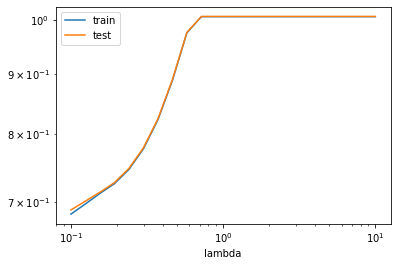

In [16]:
pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
           'test': pd.DataFrame(-test_scores).mean(1)},
           axis=1)\
    .pipe(np.sqrt)\
    .set_index(pd.Index(lambda_, name='lambda'))\
    .plot(logx=True, logy=True)

plt.show()

In [23]:
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))

# outer loop: lambdas
meanseCV = []
for lambda__ in lambda_:    
    # inner loop: folds
    meanseCV_ = []    
    for train_index, val_index in folds :        
        # train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                                     StandardScaler(),
                                     Lasso(max_iter = 10000, alpha=lambda__, tol=tol))            
        X_train, y_train, = X_dev[train_index], y_dev[train_index]
        X_val, y_val = X_dev[val_index], y_dev[val_index] 
        pipe_lassoCV.fit(X_train, y_train)        
        meanseCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))
        
    # store result    
    meanseCV_.append(meanseCV) 
    
# convert to DataFrame
lambdaCV = pd.DataFrame(meanseCV, index=lambda_)
lambdaCV['m'] = lambdaCV.mean(axis=1)
lambda_o_ = lambdaCV['m'].nsmallest(1).index
print(lambda_o_)

Float64Index([0.1], dtype='float64')


In [24]:
pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=3, include_bias=False),
                                     StandardScaler(),
                                     Lasso(max_iter = 10000, alpha=0.1, tol=tol))

pipe_lassoCV.fit(X_dev, y_dev)
print(lambda_o_,' ',round(mse(pipe_lassoCV.predict(X_test),y_test),3), round(np.sqrt(mse(pipe_lassoCV.predict(X_test),y_test)),3))

Float64Index([0.1], dtype='float64')   0.475 0.689


Ridge

In [26]:
pipe_ridge = make_pipeline(PolynomialFeatures(degree = 3, include_bias=True), 
                           StandardScaler(),
                           Ridge(alpha = l1_ratio_, tol=tol))

train_scores, test_scores = validation_curve(estimator=pipe_ridge,
                                             X=X_train, y=y_train,
                                             param_name='ridge__alpha',
                                             param_range=l1_ratio_,
                                             scoring='neg_mean_squared_error',
                                             cv=5)

mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':l1_ratio_}).set_index('lambda')   

lambda_R = mse_score.Validation.nsmallest(1)
lambda_R = lambda_R.index
lambda_R

Float64Index([517.9474679231207], dtype='float64', name='lambda')

In [29]:
#testing
pipe_ridge = make_pipeline(PolynomialFeatures(degree = 3, include_bias=True), 
                           StandardScaler(),
                           Ridge(alpha = 100, tol=tol))

pipe_ridge.fit(X_dev, y_dev)
print(lambda_o_,' ', round(mse(pipe_ridge.predict(X_test),y_test),3), round(np.sqrt(mse(pipe_ridge.predict(X_test),y_test)),3))

Float64Index([517.9474679231207], dtype='float64', name='lambda')   1.044 1.022


In [33]:
# outer loop: lambdas
mseCV_R = []
for l1_ratio__ in l1_ratio_:    
    # inner loop: folds
    meanseCV_R = []    
    for train_idx, val_idx in folds :        
        # train model and compute MSE on test fold
        pipe_ridgeCV = make_pipeline(PolynomialFeatures(degree = 3, include_bias=True), 
                           StandardScaler(),
                           Ridge(alpha = l1_ratio__, tol=tol))          
        X_train, y_train, = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx] 
        pipe_ridgeCV.fit(X_train, y_train)        
        meanseCV_R.append(mse(pipe_ridgeCV.predict(X_val), y_val))    
        
    # store result    
    mseCV_R.append(meanseCV_R) 
    
# convert to DataFrame
lambdaCV = pd.DataFrame(mseCV_R, index=lambda_)
lambdaCV['m'] = lambdaCV.mean(axis=1)
lambda_o_ = lambdaCV['m'].nsmallest(1).index
print(lambda_o_)

Float64Index([10.0], dtype='float64')


In [34]:
pipe_ridgeCV = make_pipeline(PolynomialFeatures(degree = 3, include_bias=True), 
                           StandardScaler(),
                           Ridge(alpha = 10, tol=tol))

pipe_ridgeCV.fit(X_dev, y_dev)
print(lambda_o_,' ', round(mse(pipe_ridgeCV.predict(X_test),y_test),3), round(np.sqrt(mse(pipe_ridgeCV.predict(X_test),y_test)),3))

Float64Index([10.0], dtype='float64')   2.952 1.718


**ELASTIC NET**